In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import pickle

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
from pathos.multiprocessing import Pool

import pynumtools.kmc as kmc

mpl.rcParams['figure.figsize'] = (16, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork
from readdy_learn.example.regulation_network import sample_lsq_rates
from readdy_learn.example.regulation_network import sample_along_alpha

/srv/public/clonker/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# try to generate reg network s.t. LSQ does not work properly

### Case 1
- LSQ fits well but doesnt necessarily recover the rates (varying $\alpha$)
- In the limit of low noise (and same initial conditions), the least squares solution (almost) recovers almost the right reactions (sparsity pattern). Vary hyperparameters (alpha, ~~lambda~~)
- use more basis functions

- timestep = $8\cdot 10^{-3}$: seems O.K.
- timestep = $6\cdot 10^{-3}$: lsq still works reasonably well
- timestep = $12 \cdot 10^{-3}$: lsq begins to get worse
    - this almost works, probably need a few more frames
- timestep = $24 \cdot 10^{-3}$: lsq picks up on processes that are definitely not there, ignores some of the correct ones
    - could not reproduce correct rates with lasso

In [10]:
def plot_l1_errors(regulation_network, results, cutoff=0.):
    l1_errors = []
    l1_std = []
    keys_sorted = np.array([k for k in sorted(results.keys())])
    for key in keys_sorted:
        # shape: (n_realizations, basis funs)
        rates = np.array(results[key])
        # build difference w correct rates
        ratesdiff = np.abs(np.array([r - regulation_network.desired_rates for r in rates]))
        l1norms = np.array([np.sum(x) for x in ratesdiff])
        l1_errors.append(np.mean(l1norms))
        l1_std.append(np.std(l1norms))
    l1_errors = np.array(l1_errors)
    l1_std = np.array(l1_std)
    plt.fill_between(keys_sorted, l1_errors-l1_std, l1_errors+l1_std,
                     color='b', alpha=.5)
    #plt.errorbar(keys, l2_mean, yerr=l2_std)
    plt.plot(keys_sorted, l1_errors)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('L1 error')
    ix = np.argmin(l1_errors)
    return l1_errors[ix], ix
def get_regulation_network(timestep):
    regulation_network = RegulationNetwork()
    regulation_network.timestep = timestep
    regulation_network.realisations = 1.
    regulation_network.noise_variance = 0.
    regulation_network.initial_states = [regulation_network.initial_states[1]]
    analysis = regulation_network.generate_analysis_object(fname_prefix='case_1', fname_postfix='0')
    for i in range(len(regulation_network.initial_states)):
        analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                           noise_variance=regulation_network.noise_variance,
                                           realizations=regulation_network.realisations)
        shape = analysis.trajs[i].counts.shape
        print("n_frames={}, n_species={}".format(*shape))
    regulation_network.compute_gradient_derivatives(analysis, persist=False)
    return regulation_network, analysis
def do(timestep, fname):
    regulation_network, analysis = get_regulation_network(timestep)
    alphas = np.logspace(-6, -4, num=200)
    result = sample_along_alpha(regulation_network, alphas=alphas)
    lsq_rates = analysis.least_squares(0, tol=1e-16, recompute=True, persist=False, verbose=False)
    ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
    plt.title('LSQ')
    plt.show()
    error, ix = plot_l1_errors(regulation_network, result)
    plt.show()
    ana.plot_rates_bar(regulation_network.desired_rates, np.array(result[alphas[ix]]).squeeze())
    plt.title('regularized')
    plt.show()
    
    data = {
        'regularized_rates': result,
        'lsq_rates': lsq_rates
    }
    
    print("minimal l1 error: {} (ix {})".format(error, ix))
    with open(fname, 'wb') as f:
        pickle.dump(data, f)
def load_results(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
def show_results(fname):
    print("loading results from {}....".format(fname))
    regulation_network, analysis = get_regulation_network(1e-3)
    alphas = np.logspace(-6, -4, num=200)
    
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    
    result = data['regularized_rates']
    lsq_rates = data['lsq_rates']
    
    ana.plot_rates_bar(regulation_network.desired_rates, lsq_rates)
    plt.title('LSQ')
    plt.show()
    error, ix = plot_l1_errors(regulation_network, result)
    plt.show()
    ana.plot_rates_bar(regulation_network.desired_rates, np.array(result[alphas[ix]]).squeeze())
    plt.title('regularized')
    plt.show()
    print("minimal l1 error: {} (ix {})".format(error, ix))
def do_or_dont(dt, fname):
    if os.path.exists(fname):
        show_results(fname)
    else:
        do(dt, fname)

# the plots

In [65]:
results = load_results('case_1_dt_5e-3.pickle')

In [66]:
lsq = results['lsq_rates']
reg = results['regularized_rates'][list(results['regularized_rates'].keys())[66]][0]

In [67]:
def uniqueify(mylist):
    used = []
    unique = [x for x in mylist if x not in used and (used.append(x) or True)]
    return unique

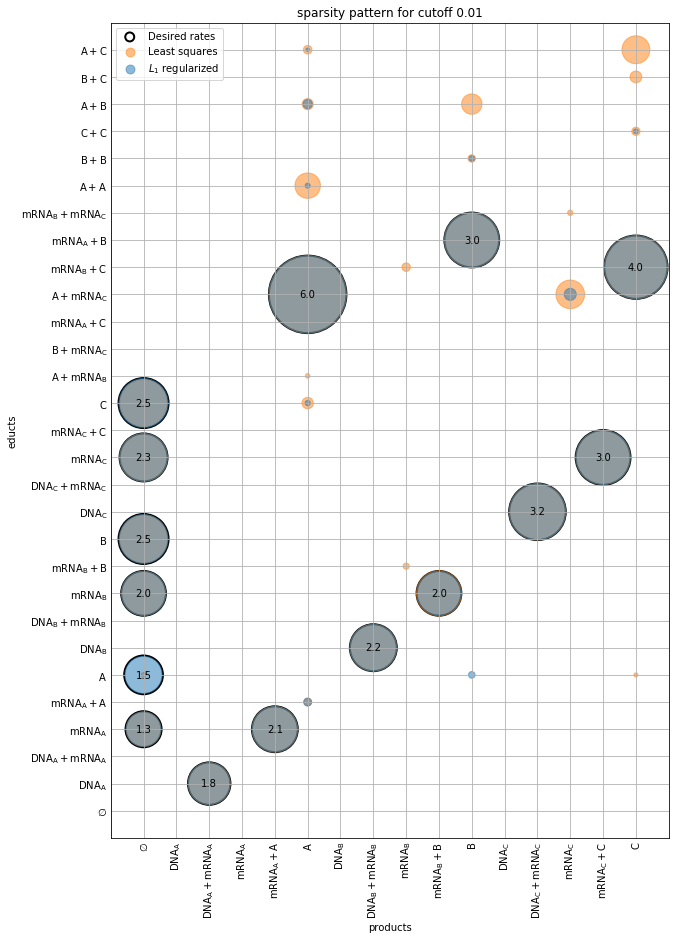

In [88]:
regulation_network = RegulationNetwork()
bfc = regulation_network.get_bfc()
# axis names...
species_mapping = {
    -1: '\emptyset',
    0: '\mathrm{DNA}_\mathrm{A}',
    1: '\mathrm{mRNA}_\mathrm{A}',
    2: '\mathrm{A}',
    3: '\mathrm{DNA}_\mathrm{B}',
    4: '\mathrm{mRNA}_\mathrm{B}',
    5: '\mathrm{B}',
    6: '\mathrm{DNA}_\mathrm{C}',
    7: '\mathrm{mRNA}_\mathrm{C}',
    8: '\mathrm{C}'
}

# collect possible educts and products
involved_species_and_pairs = [(-1,)]
for fun in bfc.functions:
    if isinstance(fun, basis.ConversionReaction):
        involved_species_and_pairs += [(fun.type1,), (fun.type2,)]
    elif isinstance(fun, basis.FusionReaction):
        involved_species_and_pairs += [sorted((fun.type_from1, fun.type_from2)), (fun.type_to,)]
    elif isinstance(fun, basis.FissionReaction):
        involved_species_and_pairs += [(fun.type_from,), sorted((fun.type_to1, fun.type_to2))]
    elif isinstance(fun, basis.DecayReaction):
        involved_species_and_pairs += [(fun.type_from,)]
    else:
        raise ValueError("unknown reaction type {}".format(fun))
involved_species_and_pairs = uniqueify(involved_species_and_pairs)

axlabels = []
for tup in involved_species_and_pairs:
    inner = [species_mapping[x] for x in tup]
    inner = " + ".join(inner)
    axlabels.append(r'${}$'.format(inner))
        
step = 2.
N = np.arange(0, step+step*len(axlabels), step)

Nx = N[:17]

fig, ax = plt.subplots(1,1, figsize=(10, 15))

ax.set_xlim(left=0, right=len(Nx)*step)
ax.set_xticks(step + Nx, minor=False)
ax.set_xticklabels(axlabels[:len(Nx)-1], rotation='vertical')
ax.set_xticks(Nx, minor=True)

ax.set_ylim(bottom=0, top=len(N)*step)
ax.set_yticks(step + N)
ax.set_yticklabels(axlabels)
ax.set_yticks(N, minor=True)

# hide ticks
ax.tick_params(which='both', axis='both', length=0, width=0)

ax.grid(which='minor')

desired_rates_matrix = np.zeros((len(axlabels), len(axlabels)))
lsq_rates_matrix = np.zeros_like(desired_rates_matrix)
regularized_rates_matrix = np.zeros_like(desired_rates_matrix)
for idx, fun in enumerate(bfc.functions):
    if isinstance(fun, basis.ConversionReaction):
        ix1 = involved_species_and_pairs.index((fun.type1,))
        ix2 = involved_species_and_pairs.index((fun.type2,))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    elif isinstance(fun, basis.FusionReaction):
        ix1 = involved_species_and_pairs.index(sorted((fun.type_from1, fun.type_from2)))
        ix2 = involved_species_and_pairs.index((fun.type_to,))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    elif isinstance(fun, basis.FissionReaction):
        ix1 = involved_species_and_pairs.index((fun.type_from,))
        ix2 = involved_species_and_pairs.index(sorted((fun.type_to1, fun.type_to2)))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    elif isinstance(fun, basis.DecayReaction):
        ix1 = involved_species_and_pairs.index((fun.type_from,))
        ix2 = 0
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    else:
        raise ValueError("unknown reaction type {}".format(fun))
    lsq_rates_matrix[ix1, ix2] = lsq[idx]
    regularized_rates_matrix[ix1, ix2] = reg[idx]

scatter_lsq_x = []
scatter_lsq_y = []
scatter_lsq_s = []

scatter_reg_x = []
scatter_reg_y = []
scatter_reg_s = []
    
scatter_x = []
scatter_y = []
scatter_s = []

best_cutoff = 0
for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if desired_rates_matrix[i, j] == 0 and regularized_rates_matrix[i, j] != 0:
            best_cutoff = max(best_cutoff, regularized_rates_matrix[i, j])

cutoff = .01#best_cutoff

for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if lsq_rates_matrix[i, j] > cutoff:
            scatter_lsq_x.append(i)
            scatter_lsq_y.append(j)
            scatter_lsq_s.append(lsq_rates_matrix[i, j])
        if regularized_rates_matrix[i, j] > cutoff:
            scatter_reg_x.append(i)
            scatter_reg_y.append(j)
            scatter_reg_s.append(regularized_rates_matrix[i, j])
        if desired_rates_matrix[i, j] > cutoff:
            scatter_x.append(i)
            scatter_y.append(j)
            scatter_s.append(desired_rates_matrix[i, j])

scatter_x = step + step*np.array(scatter_x)
scatter_y = step + step*np.array(scatter_y)
scatter_s = 1000.*np.array(scatter_s)
plt.scatter(scatter_y, scatter_x, s=scatter_s, 
            edgecolors='k', facecolors='none', label='Desired rates', linewidths=2, marker='o')
        
scatter_lsq_x = step + step * np.array(scatter_lsq_x)            
scatter_lsq_y = step + step * np.array(scatter_lsq_y)            
scatter_lsq_s = 1000.*np.array(scatter_lsq_s)
plt.scatter(scatter_lsq_y, scatter_lsq_x, s=scatter_lsq_s, alpha=.5, facecolors='C1', label='Least squares')

scatter_reg_x = step + step * np.array(scatter_reg_x)            
scatter_reg_y = step + step * np.array(scatter_reg_y)            
scatter_reg_s = 1000.*np.array(scatter_reg_s)
plt.scatter(scatter_reg_y, scatter_reg_x, s=scatter_reg_s, edgecolors='C0', 
            facecolors='C0', label=r'$L_1$ regularized', linewidths=1, alpha=.5)

ix = 0
for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if desired_rates_matrix[i, j] != 0:
            ax.annotate('{}'.format(desired_rates_matrix[i, j]), 
                        xy=(scatter_y[ix], scatter_x[ix]),
                        horizontalalignment='center', verticalalignment='center')
            ix += 1
        

lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle._sizes = [80]
    
ax.set_xlabel('products')
ax.set_ylabel('educts')
ax.set_title('sparsity pattern for cutoff {}'.format(cutoff))
plt.show()

# dt = 5e-3, 600 frames

n_frames=600, n_species=9


HBox(children=(HBox(children=(Label(value='sample for alphas 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

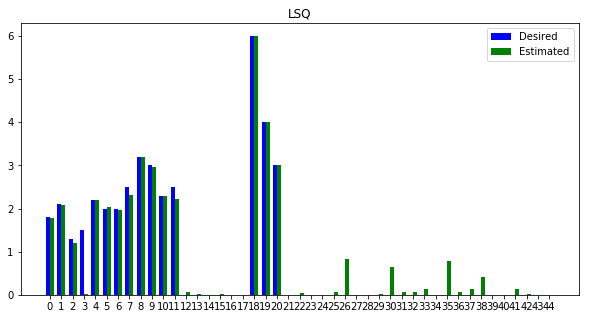

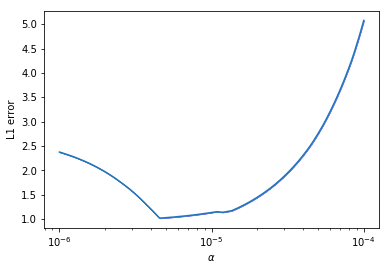

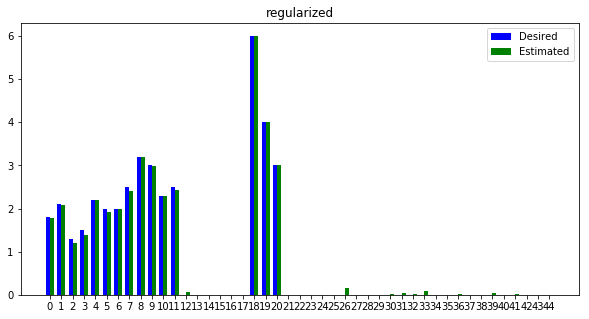

minimal l1 error: 1.020565064379289 (ix 66)


In [64]:
do_or_dont(5e-3, 'case_1_dt_5e-3.pickle')

# dt = 6e-3, 500 frames

loading results from case_1_dt_6e-3.pickle....
n_frames=3000, n_species=9


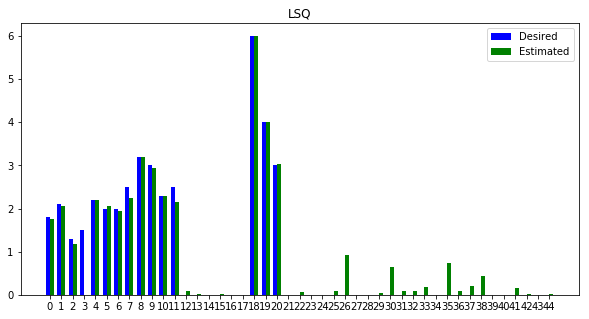

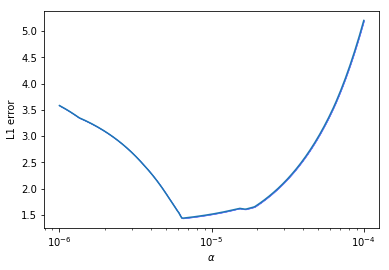

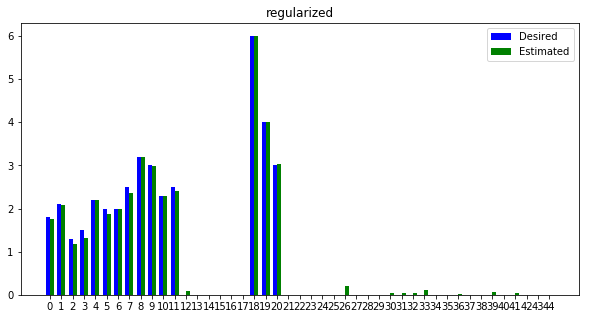

minimal l1 error: 1.4381371069862432 (ix 81)


In [3]:
do_or_dont(6e-3, 'case_1_dt_6e-3.pickle')

# dt = 7e-3

loading results from case_1_dt_7e-3.pickle....
n_frames=3000, n_species=9


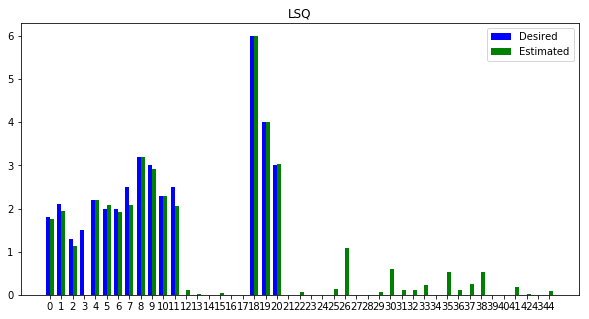

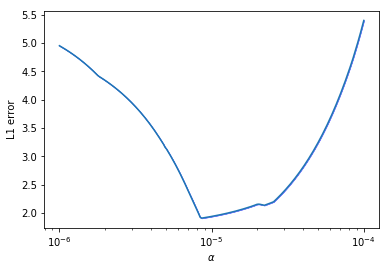

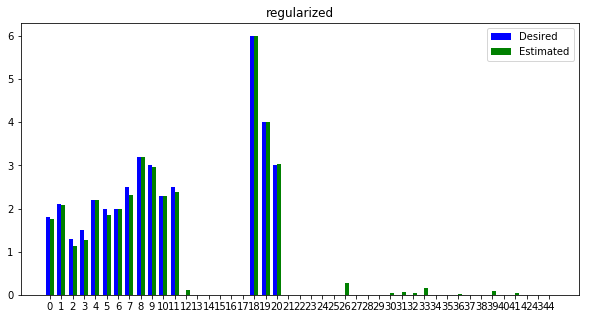

minimal l1 error: 1.910128688276026 (ix 93)


In [4]:
do_or_dont(7e-3, 'case_1_dt_7e-3.pickle')

# dt = 9e-3, 334 frames

loading results from case_1_dt_9e-3.pickle....
n_frames=3000, n_species=9


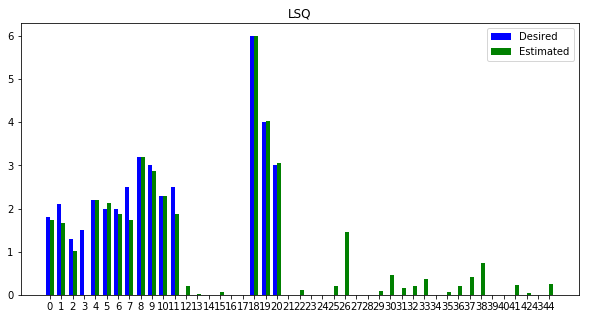

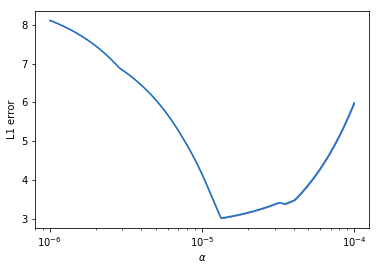

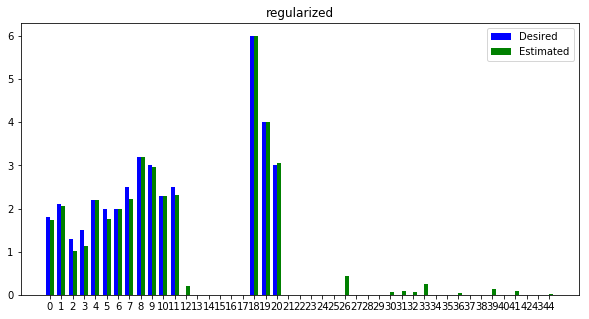

minimal l1 error: 3.0118495047914533 (ix 112)


In [5]:
do_or_dont(9e-3, 'case_1_dt_9e-3.pickle')

# dt = 8e-3, 375 frames

loading results from case_1_dt_8e-3.pickle....
n_frames=3000, n_species=9


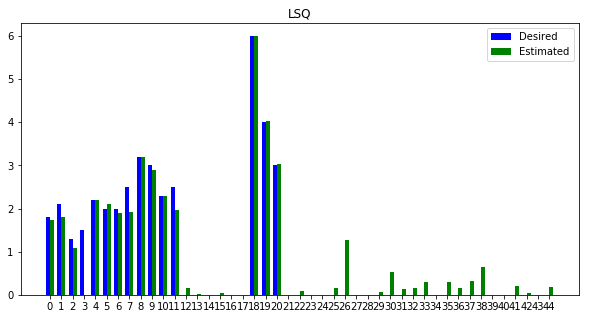

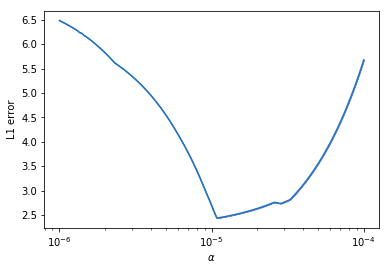

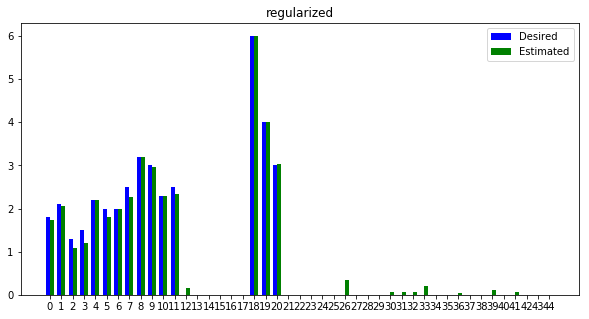

minimal l1 error: 2.4413878581035404 (ix 103)


In [6]:
do_or_dont(8e-3, 'case_1_dt_8e-3.pickle')

# dt = 12e-3, 250 frames

loading results from case_1_dt_12e-3.pickle....
n_frames=3000, n_species=9


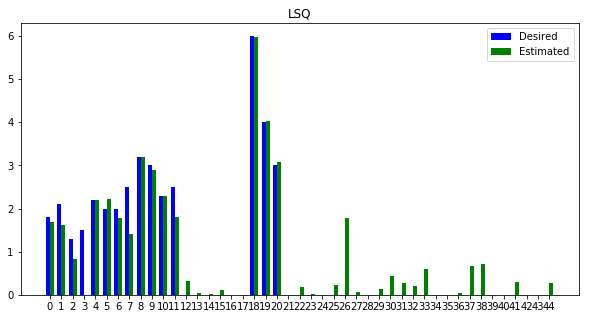

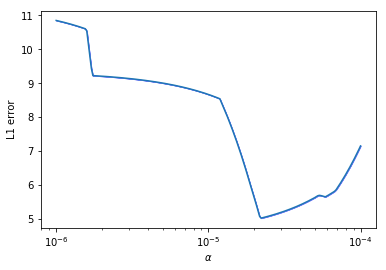

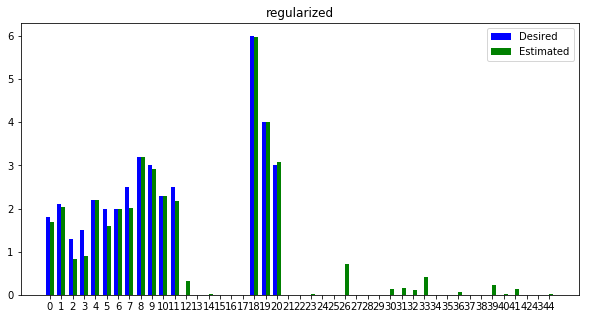

minimal l1 error: 5.031535876369794 (ix 134)


In [7]:
do_or_dont(12e-3, 'case_1_dt_12e-3.pickle')

# dt = 16e-3, 188 frames

loading results from case_1_dt_16e-3.pickle....
n_frames=3000, n_species=9


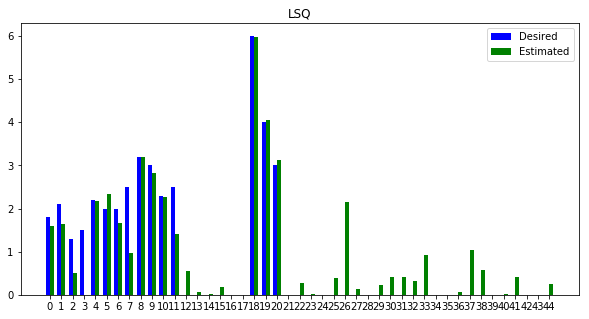

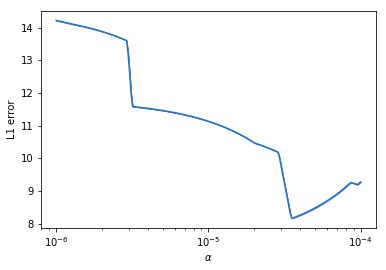

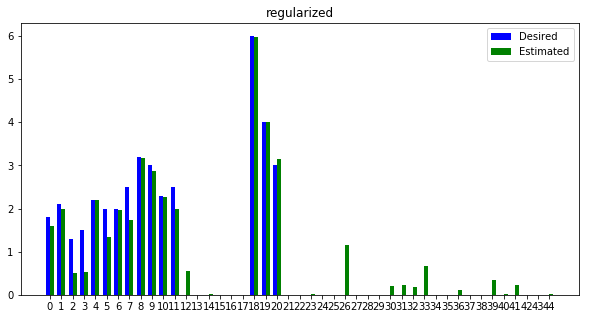

minimal l1 error: 8.165940035090607 (ix 154)


In [8]:
do_or_dont(16e-3, 'case_1_dt_16e-3.pickle')

# dt = 24e-3, 125 frames

loading results from case_1_dt_24e-3.pickle....
n_frames=3000, n_species=9


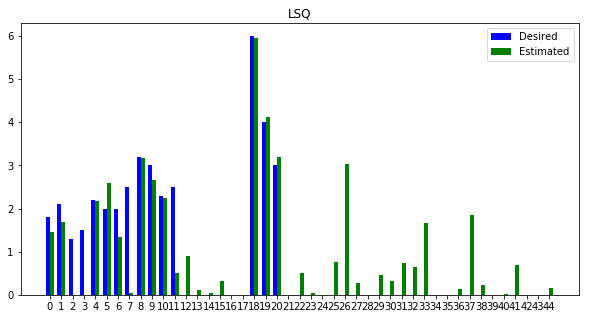

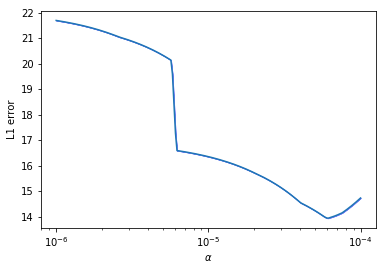

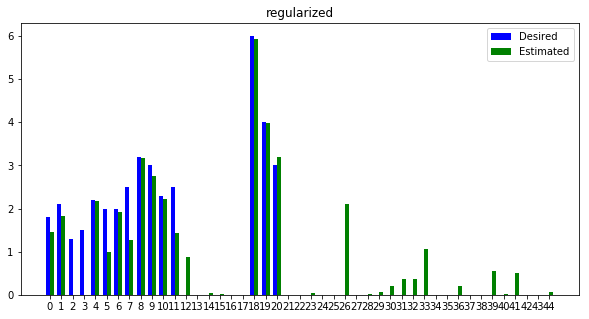

minimal l1 error: 13.943986870579032 (ix 178)


In [9]:
do_or_dont(24e-3, 'case_1_dt_24e-3.pickle')

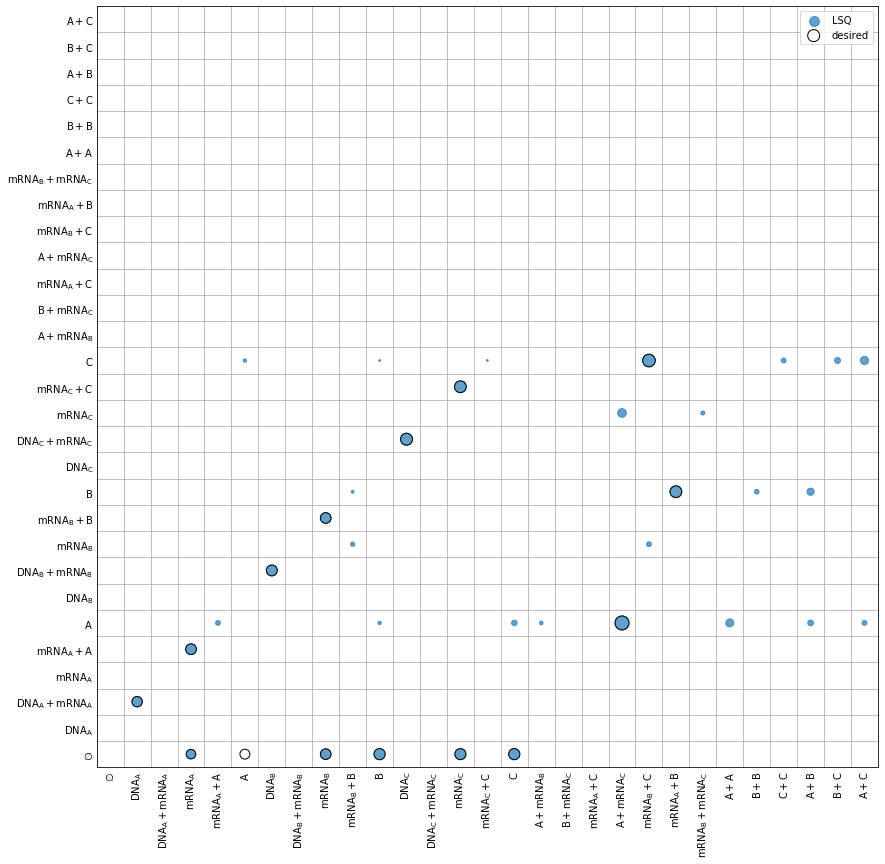

In [63]:
regulation_network = RegulationNetwork()
bfc = regulation_network.get_bfc()
# axis names...
species_mapping = {
    -1: '\emptyset',
    0: '\mathrm{DNA}_\mathrm{A}',
    1: '\mathrm{mRNA}_\mathrm{A}',
    2: '\mathrm{A}',
    3: '\mathrm{DNA}_\mathrm{B}',
    4: '\mathrm{mRNA}_\mathrm{B}',
    5: '\mathrm{B}',
    6: '\mathrm{DNA}_\mathrm{C}',
    7: '\mathrm{mRNA}_\mathrm{C}',
    8: '\mathrm{C}'
}

# collect possible educts and products
involved_species_and_pairs = [(-1,)]
for fun in bfc.functions:
    if isinstance(fun, basis.ConversionReaction):
        involved_species_and_pairs += [(fun.type1,), (fun.type2,)]
    elif isinstance(fun, basis.FusionReaction):
        involved_species_and_pairs += [sorted((fun.type_from1, fun.type_from2)), (fun.type_to,)]
    elif isinstance(fun, basis.FissionReaction):
        involved_species_and_pairs += [(fun.type_from,), sorted((fun.type_to1, fun.type_to2))]
    elif isinstance(fun, basis.DecayReaction):
        involved_species_and_pairs += [(fun.type_from,)]
    else:
        raise ValueError("unknown reaction type {}".format(fun))
involved_species_and_pairs = uniqueify(involved_species_and_pairs)

axlabels = []
for tup in involved_species_and_pairs:
    inner = [species_mapping[x] for x in tup]
    inner = " + ".join(inner)
    axlabels.append(r'${}$'.format(inner))
        
step = 2.
N = np.arange(0, step*len(axlabels), step)

fig, ax = plt.subplots(1,1, figsize=(14, 14))

ax.set_xlim(left=0, right=len(N)*step)
ax.set_xticks(.5*step + N, minor=False)
ax.set_xticklabels(axlabels, rotation='vertical')
ax.set_xticks(N, minor=True)

ax.set_ylim(bottom=0, top=len(N)*step)
ax.set_yticks(.5*step + N)
ax.set_yticklabels(axlabels)
ax.set_yticks(N, minor=True)

# hide ticks
ax.tick_params(which='both', axis='both', length=0, width=0)

ax.grid(which='minor')

desired_rates_matrix = np.zeros((len(axlabels), len(axlabels)))
lsq_rates_matrix = np.zeros_like(desired_rates_matrix)
regularized_rates_matrix = np.zeros_like(desired_rates_matrix)
for idx, fun in enumerate(bfc.functions):
    if isinstance(fun, basis.ConversionReaction):
        ix1 = involved_species_and_pairs.index((fun.type1,))
        ix2 = involved_species_and_pairs.index((fun.type2,))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    elif isinstance(fun, basis.FusionReaction):
        ix1 = involved_species_and_pairs.index(sorted((fun.type_from1, fun.type_from2)))
        ix2 = involved_species_and_pairs.index((fun.type_to,))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    elif isinstance(fun, basis.FissionReaction):
        ix1 = involved_species_and_pairs.index((fun.type_from,))
        ix2 = involved_species_and_pairs.index(sorted((fun.type_to1, fun.type_to2)))
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    elif isinstance(fun, basis.DecayReaction):
        ix1 = involved_species_and_pairs.index((fun.type_from,))
        ix2 = 0
        desired_rates_matrix[ix1, ix2] = regulation_network.desired_rates[idx]
    else:
        raise ValueError("unknown reaction type {}".format(fun))
    lsq_rates_matrix[ix1, ix2] = lsq[idx]
    regularized_rates_matrix[ix1, ix2] = reg[idx]

scatter_lsq_x = []
scatter_lsq_y = []
scatter_lsq_s = []

scatter_reg_x = []
scatter_reg_y = []
scatter_reg_s = []
    
scatter_x = []
scatter_y = []
scatter_s = []
for i in range(len(axlabels)):
    for j in range(len(axlabels)):
        if lsq_rates_matrix[i, j] != 0:
            scatter_lsq_x.append(i)
            scatter_lsq_y.append(j)
            scatter_lsq_s.append(lsq_rates_matrix[i, j])
        if regularized_rates_matrix[i, j] != 0:
            scatter_reg_x.append(i)
            scatter_reg_y.append(j)
            scatter_reg_s.append(regularized_rates_matrix[i, j])
        if desired_rates_matrix[i, j] != 0:
            scatter_x.append(i)
            scatter_y.append(j)
            scatter_s.append(desired_rates_matrix[i, j])

scatter_lsq_x = .5 * step + step * np.array(scatter_lsq_x)            
scatter_lsq_y = .5 * step + step * np.array(scatter_lsq_y)            
scatter_lsq_s = 80.*np.sqrt(np.array(scatter_lsq_s))
plt.scatter(scatter_lsq_x, scatter_lsq_y, s=scatter_lsq_s, alpha=.7, label='LSQ')

scatter_x = .5*step + step*np.array(scatter_x)
scatter_y = .5*step + step*np.array(scatter_y)
scatter_s = 80.*np.sqrt(np.array(scatter_s))
plt.scatter(scatter_x, scatter_y, s=scatter_s, 
            edgecolors='k', facecolors='none', label='desired', linewidths=1)

#scatter_reg_x = .5 * step + step * np.array(scatter_reg_x)            
#scatter_reg_y = .5 * step + step * np.array(scatter_reg_y)            
#scatter_reg_s = 80.*np.sqrt(np.array(scatter_reg_s))
#plt.scatter(scatter_reg_x, scatter_reg_y, s=scatter_reg_s, edgecolors='r', 
#            facecolors='none', label='Regularized', linewidths=1)

plt.legend()
plt.show()